In [1]:
import os, sys, time, scipy, random, json, statistics, glob, copy
from os.path import join as opj
import matplotlib.pyplot as plt
import numpy as np 
import nibabel as nib
import pandas as pd
from rdm_utils import plot_upper_triangular_rdm, build_rdm, upper_rdm
sys.path.append('..')
from config import TR, RUNS, VID_PER_RUN, STIMDUR, STIM_DICTS, PROJECT_DIR, SUBJECT_LIST, TASK, SCENES
from utils import get_mode_value, bootstrap_sample, calc_p, split_half_r
sys.path.append('../svm')
from model_prediction import gen_stiff_pred, cnn_stiff_pred
from scipy.stats import spearmanr, pearsonr

%autosave 5
%matplotlib inline
random.seed(9)


rois = ['physall', 'v1']
models = ['gen', 'cnn']
roi_p = 0.05
c_ls = ['0.1', '1.0', '10.0', '100.0']
kernel_ls = [f'l1-{i}' for i in c_ls]
nsub = len(SUBJECT_LIST)


Autosaving every 5 seconds


In [2]:
models_rdm, models_rdm_full = {}, {}
for model in models:
    cur_model = eval(f'{model}_stiff_pred')
    
    rdm_model = np.zeros((len(SCENES), len(SCENES)))
    for i in range(len(SCENES)):
        for j in range(i+1, len(SCENES)):
            scene_i_stiff = random.choices(cur_model[SCENES[i]+'_0.5_2.0'], k=nsub*5)
            scene_i_soft = random.choices(cur_model[SCENES[i]+'_0.5_0.0078125'], k=nsub*5)
            scene_j_stiff = random.choices(cur_model[SCENES[j]+'_0.5_2.0'], k=nsub*5)
            scene_j_soft = random.choices(cur_model[SCENES[j]+'_0.5_0.0078125'], k=nsub*5)
            
            mean_scene_i = np.mean(scene_i_stiff) + np.mean(scene_i_soft)
            mean_scene_j = np.mean(scene_j_stiff) + np.mean(scene_j_soft)
            rdm_model[i,j] = abs(mean_scene_i - mean_scene_j) # this is distance
            
    rdm_model = np.triu(rdm_model, k=1)
    models_rdm_full[model] = rdm_model
    models_rdm[model] = 1-upper_rdm(rdm_model) # change to similarity
    
    
r_models = spearmanr(models_rdm['cnn'], models_rdm['gen'])[0]
print(f'RDM prediction of two models, r = {r_models}')  

RDM prediction of two models, r = 0.14285714285714288


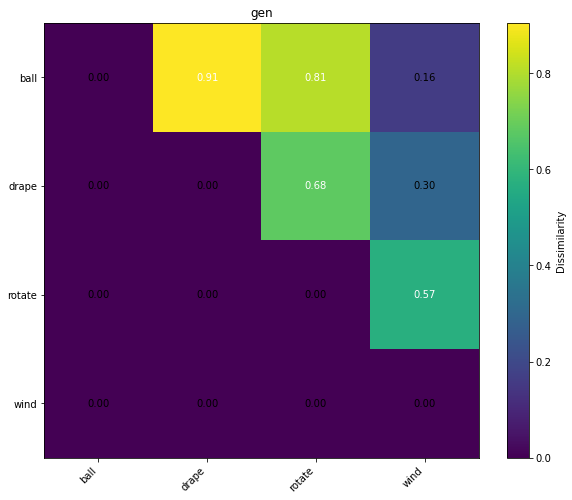

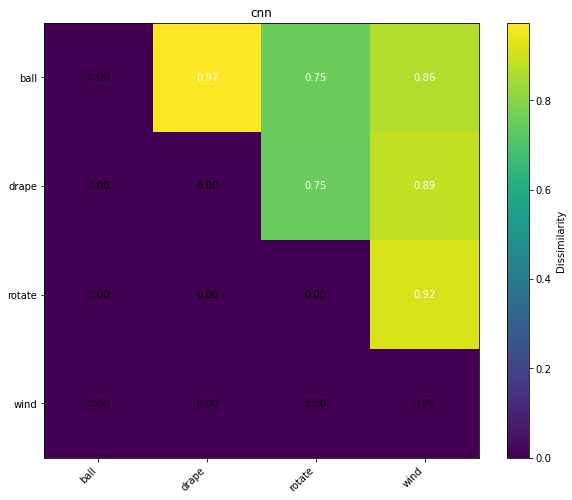

In [3]:
for model in models:
    plot_upper_triangular_rdm(SCENES, models_rdm[model], model)

In [4]:
human_rdm_root_dir = opj(PROJECT_DIR, 'output', 'rdm', 'train1_test3', TASK)

bootn = 10000


for roi in rois:
    print('\n')
    print('-----------------------------------')
    print(f'-----------   {roi}   -----------')
    print('-----------------------------------')
    for c in c_ls:
        print('\n')
        cur_human_rdm_dir = opj(human_rdm_root_dir, f'{roi}-0.05', f'l1-{c}')

        file_pattern = '*.json*'
        matching_files = glob.glob(f"{cur_human_rdm_dir}/{file_pattern}")

        flag = True
        for file in matching_files:
            with open(file, 'r') as f:
                data = json.load(f)
                if flag:
                    flag = False
                    all_data = copy.deepcopy(data)
                    for key_sub in all_data.keys():
                        for key_scene in all_data[key_sub].keys():
                            all_data[key_sub][key_scene] = [all_data[key_sub][key_scene]]
                else:
                    for key_sub in all_data.keys():
                        for key_scene in all_data[key_sub].keys():
                            all_data[key_sub][key_scene].append(data[key_sub][key_scene])

                            
        ### across multiple iterations
        all_data_mean = copy.deepcopy(all_data)
        for key_sub in all_data.keys():
            for key_scene in all_data[key_sub].keys():
                all_data_mean[key_sub][key_scene] = get_mode_value(all_data[key_sub][key_scene])

        ### the rdm and r for each subject
        rdm_all_subs, r_gen, r_cnn = {}, {}, {}
        for sub in SUBJECT_LIST:
            if sub in all_data_mean:
                rdm_all_subs[sub] = build_rdm(all_data_mean[sub], SCENES, plot=False)
                for model in ['gen', 'cnn']:
                    r = spearmanr(models_rdm[model], rdm_all_subs[sub])[0]
                    eval(f'r_{model}')[sub] = r

        ###############################################
        ###### Method 1
        ### bootstrap to get p values
        mean_gen_r = round(np.mean(list(r_gen.values())), 3)
        mean_cnn_r = round(np.mean(list(r_cnn.values())), 3)

        bootstrap_gen_r = [np.mean(bootstrap_sample(list(r_gen.values()))) for _ in range(bootn)]
        bootstrap_cnn_r = [np.mean(bootstrap_sample(list(r_cnn.values()))) for _ in range(bootn)]

        bootstrap_mean_gen_r = round(np.mean(bootstrap_gen_r),3)
        bootstrap_mean_cnn_r = round(np.mean(bootstrap_cnn_r),3)

        bootstrap_gen_p = calc_p(bootstrap_gen_r)
        bootstrap_cnn_p = calc_p(bootstrap_cnn_r)

        print(f'@@@ cor(human, gen)={mean_gen_r}(bootr={bootstrap_mean_gen_r}), p={bootstrap_gen_p}')
        print(f'@@@ cor(human, cnn)={mean_cnn_r}(bootr={bootstrap_mean_cnn_r}), p={bootstrap_cnn_p}')

        
        ###############################################
        ###### Method 2
        ###
        print('@@@@@@@@@@@@@@@@@@@@@@@@@')
        my_split_half_data = np.array(list(rdm_all_subs.values()))
        split_half_cor, split_half_p = split_half_r(my_split_half_data)
        print(f'@@@ split_half_cor={split_half_cor}, split_half_p is {split_half_p}')


        rdm_avg_all_subs = np.mean(np.array(list(rdm_all_subs.values())), axis=0)
        gen_r = round(spearmanr(models_rdm['gen'], rdm_avg_all_subs)[0], 3)
        cnn_r = round(spearmanr(models_rdm['cnn'], rdm_avg_all_subs)[0], 3)

        bootstrap_r_gen, bootstrap_r_cnn = [], []
        for _ in range(bootn):
            cur_data = np.mean(bootstrap_sample(my_split_half_data), axis=0)
            bootstrap_r_gen.append(spearmanr(cur_data, models_rdm['gen'])[0])
            bootstrap_r_cnn.append(spearmanr(cur_data, models_rdm['cnn'])[0])
        bootstrap_p_gen = calc_p(bootstrap_r_gen) 
        bootstrap_p_cnn = calc_p(bootstrap_r_cnn) 
        print(f'@@@ r(human, gen)={gen_r}, p={bootstrap_p_gen}; r(human, cnn) = {cnn_r}, p={bootstrap_p_cnn}')




-----------------------------------
-----------   physall   -----------
-----------------------------------


@@@ cor(human, gen)=0.096(bootr=0.098), p=0.2618
@@@ cor(human, cnn)=-0.128(bootr=-0.128), p=0.1932
@@@@@@@@@@@@@@@@@@@@@@@@@
@@@ split_half_cor=0.224, split_half_p is 0.582
@@@ r(human, gen)=0.771, p=0.1126; r(human, cnn) = -0.429, p=0.3524


@@@ cor(human, gen)=0.205(bootr=0.204), p=0.0484
@@@ cor(human, cnn)=-0.061(bootr=-0.062), p=0.4574
@@@@@@@@@@@@@@@@@@@@@@@@@
@@@ split_half_cor=0.269, split_half_p is 0.475
@@@ r(human, gen)=0.829, p=0.0418; r(human, cnn) = -0.371, p=0.549


@@@ cor(human, gen)=0.299(bootr=0.298), p=0.0016
@@@ cor(human, cnn)=-0.03(bootr=-0.029), p=0.7214
@@@@@@@@@@@@@@@@@@@@@@@@@
@@@ split_half_cor=0.464, split_half_p is 0.171
@@@ r(human, gen)=0.943, p=0.0082; r(human, cnn) = -0.086, p=0.9304


@@@ cor(human, gen)=0.276(bootr=0.274), p=0.0046
@@@ cor(human, cnn)=0.029(bootr=0.029), p=0.7472
@@@@@@@@@@@@@@@@@@@@@@@@@
@@@ split_half_cor=0.406, split_ha